In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Import data



In [2]:
df = pd.read_csv("data.csv")
cols = ['Text', 'Sentiment', 'Timestamp', 'Likes', 'Retweets', 'Hashtags', 'Platform', 'Country']
df.head()

,Text,Sentiment,Timestamp,Likes,Retweets,Hashtags,Platform,Country
0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,30.0,15.0,#Nature #Park,Twitter,USA
1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,10.0,5.0,#Traffic #Morning,Twitter,Canada
2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,40.0,20.0,#Fitness #Workout,Instagram,USA
3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,15.0,8.0,#Travel #Adventure,Facebook,UK
4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,25.0,12.0,#Cooking #Food,Instagram,Australia


In [3]:
df['Timestamp'].dtypes
# convert to datetime type
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['Hour'] = df['Timestamp'].dt.hour
df['Text_Length'] = df['Text'].apply(lambda x: len(x))

In [4]:
df = df.sort_values('Timestamp',ascending=True)
df = df.reset_index(drop=True)
df.head()

,Text,Sentiment,Timestamp,Likes,Retweets,Hashtags,Platform,Country,Year,Month,Day,Hour,Text_Length
0,"Revisiting old memories, feeling a sense of e...",Elation,2010-05-15 15:30:00,40.0,20.0,#Elation #Memories,Twitter,Canada,2010,5,15,15,54
1,Contentment in the simplicity of a quiet Sund...,Contentment,2010-08-15 10:00:00,60.0,30.0,#Contentment #SundayMood,Twitter,Australia,2010,8,15,10,56
2,Contentment in the embrace of a loved one. ...,Contentment,2010-11-12 20:20:00,60.0,30.0,#Contentment #Love,Twitter,India,2010,11,12,20,54
3,"Embracing the beauty of nature, a moment of c...",Contentment,2011-06-20 14:45:00,50.0,25.0,#Contentment #Nature,Facebook,India,2011,6,20,14,58
4,Serenity found in the beauty of a sunset by t...,Serenity,2011-07-22 18:30:00,45.0,22.0,#Serenity #SunsetViews,Instagram,Canada,2011,7,22,18,55


## Preprocess
Since there are 191 unique sentiment labels, we group them into three broader categories: **positive**, **neutral**, and **negative**, to reduce feature dimensionality.

In [5]:
print(f"Number of unique sentiments: {len(df['Sentiment'].unique())}")

Number of unique sentiments: 191


In [6]:
df['Sentiment'].unique()

array(['Elation', 'Contentment', 'Serenity', 'Fulfillment', 'Gratitude',
       'Hope', 'Empowerment', 'Miscalculation', 'Grief', 'Suspense',
       'Compassion', 'Marvel', 'ArtisticBurst', 'Creativity',
       'Determination', 'Curiosity', 'Happy', 'Runway Creativity',
       'Satisfaction', 'Bitterness', 'Envisioning History', 'Tenderness',
       'Whimsy', 'Despair', 'Awe', 'Pride', 'Connection', 'Solitude',
       'Loneliness', 'Disgust', 'Contemplation', 'Darkness', 'Pressure',
       'Harmony', 'Positivity', 'Celestial Wonder', 'Boredom',
       'Appreciation', 'Inspiration', 'LostLove', 'Exploration',
       'Nostalgia', 'Betrayal', 'Resentment', 'Frustration', 'Melancholy',
       'Envy', 'Joy', 'Thrilling Journey', 'Regret', 'Arousal',
       'Obstacle', 'Wonderment', 'EmotionalStorm', 'Heartbreak',
       'Desolation', 'Captivation', 'InnerJourney', 'Mindfulness',
       'Reverence', 'Calmness', 'Success', 'Spark', 'Jealous',
       'Empathetic', 'Happiness', 'Enthusiasm', 'D

In [7]:
# sentiment mapping dictionary
positive_sentiments = { 'Elation', 'Contentment', 'Serenity', 'Gratitude', 'Hope', 'Empowerment',
    'Creativity', 'Determination', 'Curiosity', 'Happy', 'Satisfaction', 'Awe', 'Pride', 'Connection',
    'Harmony', 'Positivity', 'Appreciation', 'Inspiration', 'Joy', 'Thrilling Journey', 'Success', 'Spark',
    'Enthusiasm', 'Reflection', 'Grandeur', 'Wonder', 'Zest', 'Playful', 'Friendship', 'Excitement',
    'Euphoria', 'Adventure', 'Vibrancy', 'Romance', 'Kindness', 'Energy', 'Admiration', 'Happiness',
    'Inspired', 'Emotion', 'Proud', 'Coziness', 'Accomplishment', 'Confidence', 'Breakthrough',
    'Free-spirited', 'Colorful', 'Engagement', 'Resilience', 'Adrenaline', 'Heartwarming', 'FestiveJoy',
    'PlayfulJoy', 'Confident', 'Touched', 'DreamChaser', 'Freedom', 'Sympathy', 'Enchantment',
    'Compassionate', 'Optimism', 'Tranquility', 'Acceptance', 'Blessed', 'Rejuvenation', 'Imagination',
    'Overjoyed', 'Celebration', 'Motivation', 'Grateful', 'Solace', 'Hopeful', 'Radiance', 'Triumph',
    'Love', 'Winter Magic', 'Positive', 'Enjoyment', 'Affection', 'Adoration', 'Kind', 'Creative Inspiration',
    'Joy in Baking', 'Relief'
}

negative_sentiments = {
    'Miscalculation', 'Grief', 'Bitterness', 'Despair', 'Solitude', 'Loneliness', 'Disgust', 'Darkness',
    'Pressure', 'LostLove', 'Betrayal', 'Resentment', 'Frustration', 'Melancholy', 'Envy', 'Regret',
    'Arousal', 'Obstacle', 'EmotionalStorm', 'Heartbreak', 'Desolation', 'Desperation', 'Helplessness',
    'Loss', 'Ambivalence', 'Disappointment', 'Numbness', 'Sorrow', 'Anxiety', 'Frustrated', 'Exhaustion',
    'Intimidation', 'Fearful', 'Devastated', 'Heartache', 'Sadness', 'Anger', 'Fear', 'Sad', 'Hate', 'Bad',
    'Bitter', 'Shame', 'Embarrassed', 'Suffering'
}

neutral_sentiments = {
    'Suspense', 'Compassion', 'Marvel', 'ArtisticBurst', 'Runway Creativity', 'Envisioning History',
    'Tenderness', 'Whimsy', 'Contemplation', 'Celestial Wonder', 'Boredom', 'Nostalgia', 'Exploration',
    'Wonderment', 'Captivation', 'InnerJourney', 'Mindfulness', 'Reverence', 'Calmness', 'Dismissive',
    'Intrigue', 'Melodic', 'Whispers of the Past', 'Charm', 'Immersion', 'Surprise', 'Journey', 'Bittersweet',
    'Confusion', 'Isolation', 'Yearning', "Nature's Beauty", 'Amazement', 'Apprehensive', "Ocean's Freedom",
    'Ruins', 'Hypnotic', 'Challenge', 'Indifference', 'Neutral', 'Pensive', 'Mischievous'
}

# function of mapping
def map_sentiment(sentiment):
    if sentiment in positive_sentiments:
        return 'Positive'
    elif sentiment in negative_sentiments:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment_Category'] = df['Sentiment'].apply(map_sentiment)
print(df['Sentiment_Category'].value_counts())


Sentiment_Category
Positive    411
Negative    165
Neutral     156
Name: count, dtype: int64


In [8]:
df['Platform'].value_counts()

,count
Platform,
Instagram,258
Twitter,243
Facebook,231


In [9]:
df.groupby('Platform')['Sentiment_Category'].value_counts()

Platform   Sentiment_Category
Facebook   Positive              136
           Negative               52
           Neutral                43
Instagram  Positive              145
           Negative               57
           Neutral                56
Twitter    Positive              130
           Neutral                57
           Negative               56
Name: count, dtype: int64

## Feature selection

We aim to build separate models for each of the three social media platforms, as user interactions and content formats vary across them. Our goal is to investigate whether sentiment and other features can help predict the popularity of a post. To do this, we first need to define what constitutes a “popular” post.

Upon exploring the dataset, we found that the number of likes and retweets are highly correlated, with a correlation coefficient of 0.99. Therefore, we use the number of likes as the sole indicator of popularity. A post is classified as popular if its number of likes exceeds the **70th** percentile.


In [10]:
df[['Likes', 'Retweets']].corr()

,Likes,Retweets
Likes,1.000000,0.998482
Retweets,0.998482,1.000000


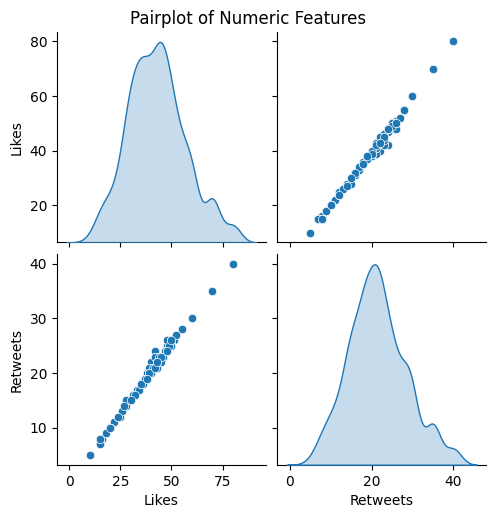

In [11]:
# pairplot of likes and retweets
sns.pairplot(df[['Likes', 'Retweets'] ], kind='scatter', diag_kind='kde')
plt.suptitle('Pairplot of Numeric Features', y=1.02)
plt.show()

In [12]:
df[['Likes','Retweets']].describe()

,Likes,Retweets
count,732.000000,732.000000
mean,42.901639,21.508197
std,14.089848,7.061286
min,10.000000,5.000000
25%,34.750000,17.750000
50%,43.000000,22.000000
75%,50.000000,25.000000
max,80.000000,40.000000


## Logistic Regression

We use logistic regression to predict whether a post will be popular on each platform. The features for each model include the sentiment category (Positive/Neutral/Negative), the hour of posting, and the number of characters in the post.

In [23]:
def train_logistic_model(df_platform):
    """Train a logistic regression model and return the model, test set, and predictions"""
    like_threshold = df_platform['Likes'].quantile(0.7)
    df_platform['Popular'] = (df_platform['Likes'] > like_threshold).astype(int)

    features = ['Sentiment_Category', 'Hour', 'Text_Length']
    X = df_platform[features]
    y = df_platform['Popular']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    categorical_features = ['Sentiment_Category']
    numeric_features = ['Hour', 'Text_Length']

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first'), categorical_features),
            ('num', 'passthrough', numeric_features)
        ]
    )

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(C=0.1, random_state=42, class_weight='balanced'))
    ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred))

    return model, X_test, y_test, y_pred


def plot_model_evaluation(model, X_test, y_test, platform_name):
    """Plot confusion matrix and ROC curve"""
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Model Evaluation for {platform_name}', fontsize=16)

    # Confusion matrix
    cm = confusion_matrix(y_test, model.predict(X_test), labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axs[0], cmap='Blues', values_format='d')

    axs[0].set_title("Confusion Matrix")

    # ROC curve
    axs[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    axs[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    axs[1].set_title('ROC Curve')
    axs[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()


def print_model_coefficients(model, feature_names, platform_name):
    """Print the feature coefficients of the logistic regression model"""
    clf = model.named_steps['classifier']
    preprocessor = model.named_steps['preprocessor']

    # Get the complete feature names (including one-hot encoded column names)
    encoded_feature_names = preprocessor.transformers_[0][1].get_feature_names_out(['Sentiment_Category'])
    full_feature_names = list(encoded_feature_names) + ['Hour', 'Text_Length']

    print(f"\n--- Coefficients for {platform_name} ---")
    for name, coef in zip(full_feature_names, clf.coef_[0]):
        print(f"{name}: {coef:.4f}")
    print(f"Intercept: {clf.intercept_[0]:.4f}")



====== Modeling for Platform: Twitter ======
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        35
           1       0.57      0.57      0.57        14

    accuracy                           0.76        49
   macro avg       0.70      0.70      0.70        49
weighted avg       0.76      0.76      0.76        49



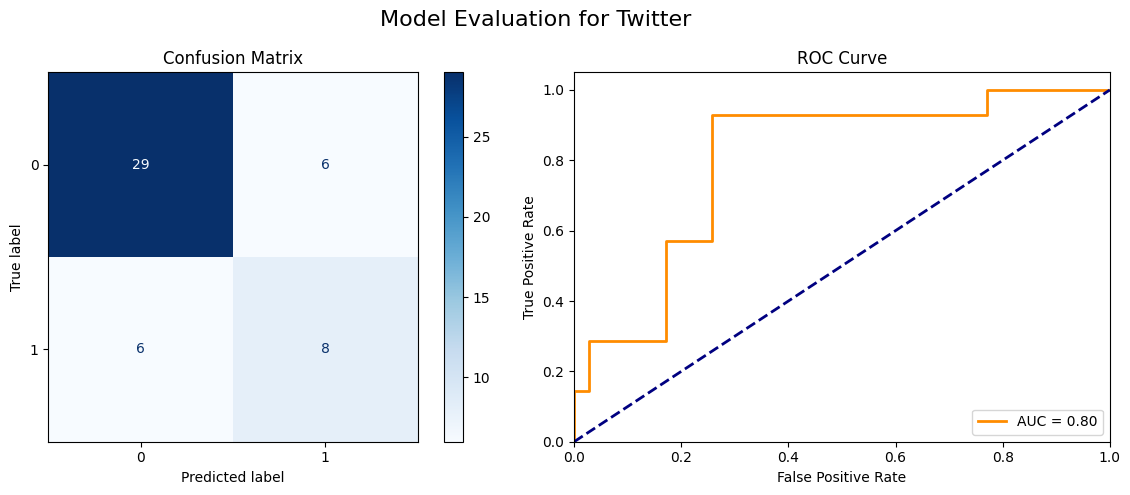


--- Coefficients for Twitter ---
Sentiment_Category_Neutral: 0.1953
Sentiment_Category_Positive: 0.4655
Hour: 0.0269
Text_Length: 0.0089
Intercept: -1.5521

====== Modeling for Platform: Facebook ======
              precision    recall  f1-score   support

           0       0.93      0.66      0.77        38
           1       0.35      0.78      0.48         9

    accuracy                           0.68        47
   macro avg       0.64      0.72      0.63        47
weighted avg       0.82      0.68      0.71        47



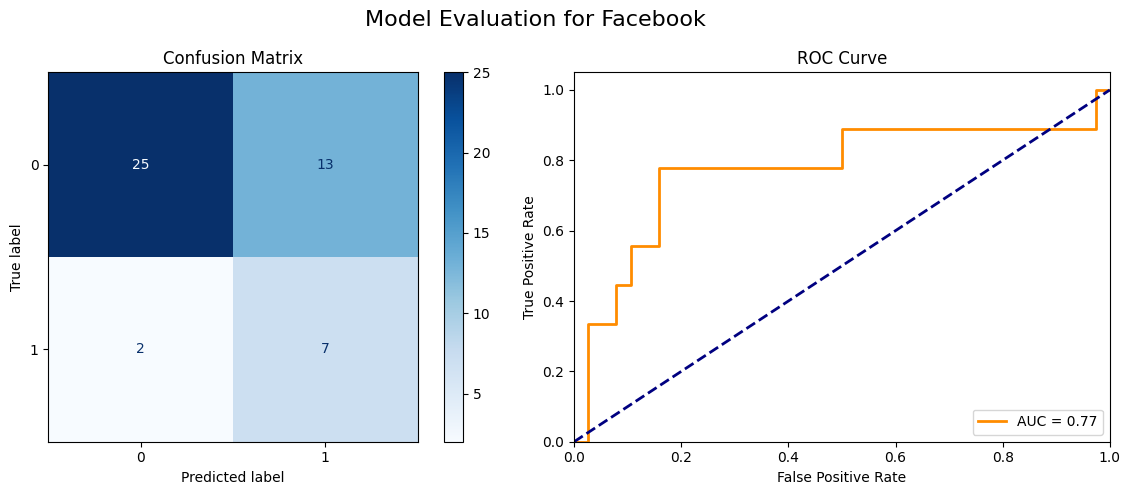


--- Coefficients for Facebook ---
Sentiment_Category_Neutral: -0.1816
Sentiment_Category_Positive: 0.4770
Hour: 0.1651
Text_Length: 0.0039
Intercept: -3.3486

====== Modeling for Platform: Instagram ======
              precision    recall  f1-score   support

           0       0.83      0.65      0.73        37
           1       0.43      0.67      0.53        15

    accuracy                           0.65        52
   macro avg       0.63      0.66      0.63        52
weighted avg       0.71      0.65      0.67        52



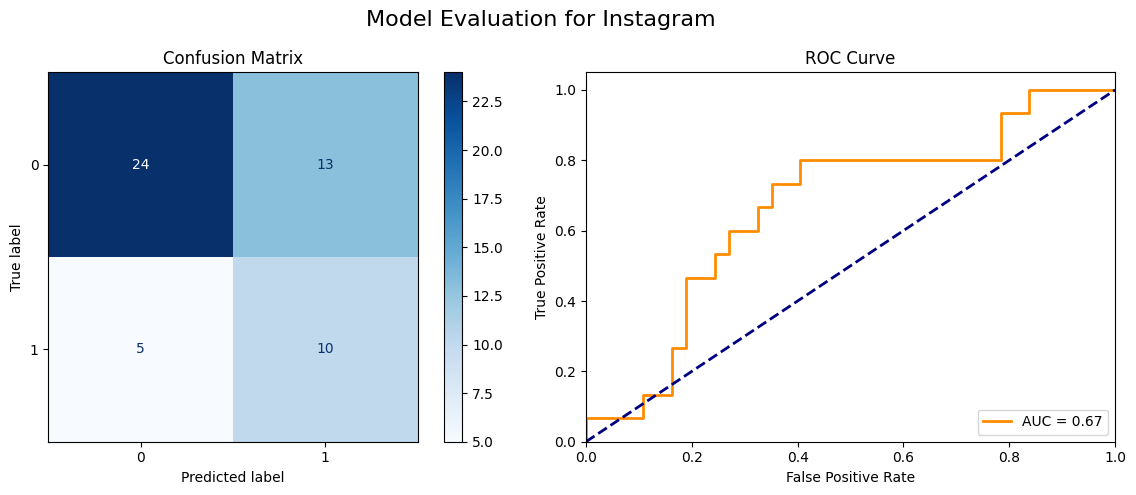


--- Coefficients for Instagram ---
Sentiment_Category_Neutral: -0.0184
Sentiment_Category_Positive: 0.3006
Hour: 0.0601
Text_Length: 0.0040
Intercept: -1.4933


In [24]:
# 3. Call the model for each platform
for platform in df['Platform'].unique():
    print(f"\n====== Modeling for Platform: {platform} ======")
    df_platform = df[df['Platform'] == platform].copy()

    model, X_test, y_test, _ = train_logistic_model(df_platform)
    plot_model_evaluation(model, X_test, y_test, platform)
    print_model_coefficients(model, ['Sentiment_Category', 'Hour', 'Text_Length'], platform)

From the ROC curves, we observe that the model achieves an AUC of 0.80 for Twitter, 0.77 for Facebook, and 0.67 for Instagram. While the coefficients vary across platforms, the coefficient for positive sentiment is consistently higher than that for neutral sentiment, suggesting that posts with positive sentiment are more likely to become popular.

The model demonstrates strong precision in identifying non-popular posts; however, its performance in correctly identifying truly popular posts is relatively weak, indicating a tendency to miss or misclassify high-engagement content.